In [1]:
%alias package {__import__('sys').executable} -m pip install --quiet --upgrade --upgrade-strategy eager %l

In [2]:
session_storage = 'downloads'

import os
os.makedirs(session_storage, exist_ok=True)

In [3]:
%package fsspec

import fsspec

fs_dataset = fsspec.filesystem(
    'simplecache', 
    target_protocol='https', 
    cache_storage=session_storage
)

In [4]:
%package numpy pandas 

import numpy as np
import pandas as pd
'''
%package swifter
import swifter
swifter.set_defaults(
    npartitions=None,
    dask_thres=1,
    scheduler='processes',
    progress_bar=True,
    progress_bar_desc=None,
    allow_dask_on_strings=True,
    force_parallel=False
)
'''

%package scikit-learn
import sklearn as skl
import sklearn.base
import sklearn.compose
#import sklearn.ensemble
import sklearn.feature_extraction
import sklearn.linear_model
import sklearn.metrics
import sklearn.model_selection
import sklearn.pipeline
#import sklearn.svm

#%package scikit-learn-intelex
#import sklearnex
#sklearnex.patch_sklearn()

#%package xgboost
#import xgboost

In [5]:
%package tensorflow tensorflow-gpu

import tensorflow as tf
from tensorflow import keras as keras

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

2022-12-03 05:16:13.762072: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-03 05:16:15.212051: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/opt/conda/lib/:/opt/conda/lib/
2022-12-03 05:16:15.212166: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/opt/c

In [6]:
%package tensorflow-addons
import tensorflow_addons as tfa

/opt/conda/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [7]:
%package scikeras

import scikeras as skeras
import scikeras.wrappers

In [8]:
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import matplotlib.pyplot as plt
def set_constrained_layout(plt):
    plt.rcParams['figure.constrained_layout.use'] = True
set_constrained_layout(plt)

plt.style.use('default')

In [9]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

def subplots(
    n, 
    ncols = 1, visible = False, 
    *args, **kwargs
):
    fig, axs = plt.subplots(
        *args, **kwargs,
        ncols=ncols, 
        nrows=int(np.ceil(n / ncols))
    )
    for ax in axs.flatten():
        ax.set(visible=visible)
    return fig, axs

## Dataset

In [10]:
# TODO
df_scripts = pd.read_pickle('./dataset.pkl', compression='gzip')

In [11]:
df_scripts

,script_name,script_text
0,No Country for Old Men Script,[\r\n\r\n\r\n \r\n NO...
1,Strangers on a Train Script,[ STRANGERS ON A TRAIN\r\n\r...
2,"Sex, Lies and Videotape Script",[\r\n\r\n<b><!--\r\n</b>if (window!= top)\r\nt...
3,Absolute Power Script,[ABSOLUTE POWER\r\n\r\n Written by\r\n ...
4,"World is not Enough, The Script",[\t\t\r\n\r\n T H E W O R L D I S ...
...,...,...
1204,Shivers Script,[\r\n\r\n\r\n ...
1205,American Psycho Script,[\r\n\r\n\r\n<b><!--\r\n</b>if (window!= top)\...
1206,Five Easy Pieces Script,[\r\n\r\n\r\n<b><!--\r\n</b>if (window!= top)\...
1207,Saving Mr. Banks Script,[\r\n\r\n\r\n ...


In [12]:
df_scripts = df_scripts.astype({
    'script_name': 'category'
})

In [13]:
df_scripts = df_scripts.explode('script_text', ignore_index=True)

In [14]:
df_scripts.dropna(inplace=True)
df_scripts.reset_index(drop=True, inplace=True)

In [15]:
df_scripts

,script_name,script_text
0,No Country for Old Men Script,\r\n\r\n\r\n \r\n NO ...
1,Strangers on a Train Script,STRANGERS ON A TRAIN\r\n\r\...
2,"Sex, Lies and Videotape Script",\r\n\r\n<b><!--\r\n</b>if (window!= top)\r\nto...
3,Absolute Power Script,ABSOLUTE POWER\r\n\r\n Written by\r\n ...
4,"World is not Enough, The Script",\t\t\r\n\r\n T H E W O R L D I S N...
...,...,...
1172,Shivers Script,\r\n\r\n\r\n ...
1173,American Psycho Script,\r\n\r\n\r\n<b><!--\r\n</b>if (window!= top)\r...
1174,Five Easy Pieces Script,\r\n\r\n\r\n<b><!--\r\n</b>if (window!= top)\r...
1175,Saving Mr. Banks Script,\r\n\r\n\r\n ...


In [16]:
#print(dataset_scripts.iloc[0]['script_text'][-1])

TODO
GOAL extract the following features from texts:

Feature engineering TODO list: 
- location: Named Entity Recognition
- character: Named Entity Recognition
    see https://keras.io/examples/nlp/ner_transformers/
    see https://towardsdatascience.com/named-entity-recognition-ner-using-keras-bidirectional-lstm-28cd3f301f54
- convo: ??

sentence embedding?

## Feature Engineering

In [17]:
def str_normalize_eol(s, eol=os.linesep):
    return str.join(eol, str.splitlines(s))

In [18]:
%package joblib

import os
import re

import joblib

class ParagraphExtractor(skl.base.TransformerMixin):
    def __init__(self,
        eol=os.linesep,
        eol_freq_min=2,
        n_jobs=1
    ):
        self.eol = eol
        self.eol_freq_min = eol_freq_min
        self.n_jobs = n_jobs

        self._pattern = re.compile(
            fr'(?:{self.eol}\s*?){{{self.eol_freq_min},}}'
        )

    def fit(self, _X, _y=None):
        return self

    def transform(self, X, _y=None):
        def _impl_single(s):
            nonlocal self
            return re.split(
                self._pattern,
                str_normalize_eol(s, eol=self.eol)
            )

        return joblib.Parallel(n_jobs=self.n_jobs)(
            joblib.delayed(_impl_single)(s)
                for s in X
        )

        
df_scripts['script_paragraphs'] = ParagraphExtractor(n_jobs=-1).fit_transform(
    df_scripts['script_text']#.iloc[:100]
)

In [19]:
df_scripts_para = (
    df_scripts[['script_name', 'script_paragraphs']]
        .explode('script_paragraphs', ignore_index=True)
)

In [20]:
df_scripts_para['script_paragraphs'] = (
    df_scripts_para['script_paragraphs'].str.strip()
)

In [21]:
df_scripts_para = df_scripts_para[
    # non-empty strings
    df_scripts_para['script_paragraphs'].astype(bool)
]

In [22]:
df_scripts_para['script_name'] = (
    df_scripts_para['script_name']
        .cat.remove_unused_categories()
)

In [23]:
df_scripts_para

,script_name,script_paragraphs
1,No Country for Old Men Script,NO COUNTRY FOR OLD MEN
2,No Country for Old Men Script,Written by
3,No Country for Old Men Script,Joel Coen & Ethan Coen
4,No Country for Old Men Script,Based on the Novel by
5,No Country for Old Men Script,Cormac McCarthy
...,...,...
1999877,Get Carter Script,Carter lies on the beach. The waves lap around...
1999878,Get Carter Script,EXT. CLIFF TOP - EARLY MORNING
1999879,Get Carter Script,Kinnear's hit man coolly dismantles his rifle....
1999880,Get Carter Script,FADE OUT:


In [24]:
# TODO rm
#df_scripts['script_paragraphs'].iloc[0][:20]

In [25]:
df_n_paras = df_scripts_para.groupby('script_name').count()

In [26]:
df_n_paras[df_n_paras['script_paragraphs'] < 10]

,script_paragraphs
script_name,
Ace Ventura: Pet Detective Script,3
American Outlaws Script,1
Days of Heaven Script,2
Erik the Viking Script,3
Fletch Script,2
Four Feathers Script,8
Highlander: Endgame Script,4
Made Script,1
Never Been Kissed Script,6


In [27]:
# TODO treat these samples separately
# e.g. those without line breaks between paragraphs 
# (so only one line break after each para)

df_scripts_outliers = df_scripts_para[
    df_scripts_para['script_name'].isin(
        df_n_paras[df_n_paras['script_paragraphs'] < 10].index
    )
]
df_scripts_outliers

,script_name,script_paragraphs
370547,Four Feathers Script,"""Four Feathers"" -- by Michael Schiffer, revise..."
370548,Four Feathers Script,<b><!--\n</b>if (window!= top)\ntop.location.h...
370549,Four Feathers Script,Four Feathers\nScreenplay by Michael Schiffer\...
370550,Four Feathers Script,EXT. TRAINING GROUND/ WESTMINSTER barracks/ LO...
370551,Four Feathers Script,COLONEL SUTCH\nThrow them away. They don't mea...
370552,Four Feathers Script,- THE CHAPEL: is filled with MILITARY MEN; Fev...
370553,Four Feathers Script,CUT TO:\nEXT. CHURCH - AFTER CEREMONY ...
370554,Four Feathers Script,THE END.
407261,Training Day Script,"""Training Day"" -- by David Ayer ..."
540920,Never Been Kissed Script,"""Never Been Kissed"""


In [28]:
df_scripts_outliers.loc[370549]['script_paragraphs']

'Four Feathers\nScreenplay by Michael Schiffer\nrevised by Hossein Amini\nbased on the book by A.E. Mason'

In [29]:
# TODO lxml to parse html
#print(df_scripts[df_scripts['script_name'] == 'They Script'].iloc[0]['script_text'][:10000])

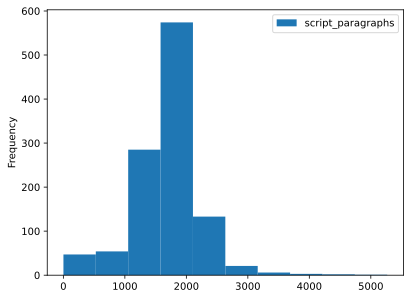

In [30]:
_ = df_n_paras.plot.hist()

## Models

### Neural Network (LSTM RNN)

#### Text Transformers

In [382]:
class KerasTextVectorizer(skl.base.TransformerMixin):
    def __init__(self, 
        vocabulary=None, **kwargs
    ):
        self._has_vocab = vocabulary is not None
        
        self.base = keras.layers.TextVectorization(
            **kwargs, 
            vocabulary=vocabulary
        )

    def fit(self, X, _y=None):
        if not self._has_vocab:
            self.base.adapt(X)

        self.base.compile()
        return self

    def transform(self, X, _y=None):
        return self.base(X)

In [381]:
%package spacy[cuda-autodetect,transformers,lookups] #spacy spacy-transformers

class SpacyTextVectorizer(KerasTextVectorizer):
    def __init__(self, **kwargs):
        import spacy
        #import spacy_transformers
        spacy.prefer_gpu()
        
        #spacy.cli.download('en_core_web_lg', False, False, '--quiet')

        nlp = spacy.load('en_core_web_lg')
        super().__init__(
            vocabulary=list(nlp.vocab.strings),
            **kwargs
        )

^C
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/conda/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.9/site-packages/pip/__main__.py", line 29, in <module>
    from pip._internal.cli.main import main as _main
  File "/opt/conda/lib/python3.9/site-packages/pip/_internal/cli/main.py", line 9, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/opt/conda/lib/python3.9/site-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/opt/conda/lib/python3.9/site-packages/pip/_internal/cli/main_parser.py", line 8, in <module>
    from pip._internal.cli import cmdoptions
  File "/opt/conda/lib/python3.9/site-packages/pip/_internal/cli/cmdoptions.py", line 21, in <module>
    from pip._vendor.packagi

#### Classifier

In [393]:
def KerasTextClassifier(*args, **kwargs):
    # see https://www.adriangb.com/scikeras/stable/advanced.html
    def _build_model(vocabulary_size, meta, compile_kwargs, params):
        input_dim = meta['X_shape_'][1:]
        output_dim = meta['n_classes_']

        # see https://www.tensorflow.org/tutorials/keras/text_classification
        model = keras.Sequential([
            keras.layers.InputLayer(input_shape=input_dim),

            keras.layers.Embedding(
                input_dim=vocabulary_size,
                output_dim=128,
                mask_zero=True
            ),

            keras.layers.Conv1D(
                filters=32, kernel_size=3, 
                padding='same', 
                activation='relu'
            ),
            keras.layers.MaxPooling1D(pool_size=10),
            keras.layers.Dropout(.1),

            keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True)),
            keras.layers.Bidirectional(keras.layers.LSTM(64)),

            keras.layers.Dense(128, activation='relu'),

            keras.layers.Dense(
                output_dim,
                activation='softmax'
            )
        ])

        model.compile(**compile_kwargs)

        return model

    return skeras.wrappers.KerasClassifier(
        _build_model, 
        *args, **kwargs,
        loss='categorical_crossentropy', 
        optimizer='adam', # TODO  
        metrics=['accuracy']
    )

#### Predictor (Vocab From Spacy)

In [387]:
%package tensorboard
%load_ext tensorboard 

^C
ERROR: Operation cancelled by user
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [369]:
%reload_ext tensorboard 


In [370]:
%tensorboard --logdir '{session_storage}/tensorboard/model_nn_spacy'

Reusing TensorBoard on port 6006 (pid 57620), started 0:27:16 ago. (Use '!kill 57620' to kill it.)

In [412]:
class TextClassifierCV(
    skl.base.BaseEstimator,
    skl.base.ClassifierMixin
):
    def __init__(self):
        pass

    def fit(self, X, y):
        self.vectorizer = (
            KerasTextVectorizer(
                max_tokens=None,
                standardize='lower_and_strip_punctuation',
                split='whitespace',
                #ngrams=(1, 2),
                output_mode='int', # TODO tf_idf
                #sparse=True,
            )
                .fit(X)
        )

        X = self.vectorizer.transform(X)
        self.base = (
            skl.model_selection.GridSearchCV(
                KerasTextClassifier(
                    vocabulary_size=self.vectorizer.base.vocabulary_size(),
                    verbose=0,
                    callbacks=[
                        keras.callbacks.TensorBoard(
                            fr'{session_storage}/tensorboard/model_nn_spacy'
                        ),
                        tfa.callbacks.TQDMProgressBar(
                            show_epoch_progress=False
                        )
                        #keras.callbacks.EarlyStopping(
                        #    monitor='loss', 
                        #    patience=3, 
                        #    min_delta=0.0001
                        #)
                    ]
                ),
                param_grid={
                    'epochs': [100],
                    'batch_size': [1024],
                    'optimizer__learning_rate': [.01]
                },
                cv=skl.model_selection.RepeatedStratifiedKFold(
                    n_splits=3, n_repeats=1
                ),
                #cv=skl.model_selection.KFold(
                #    n_splits=5, shuffle=True
                #),
                #n_jobs=-1,
                verbose=3
            )
                .fit(X, y)
        )

        return self

    def predict(self, X):
        X = self.vectorizer.transform(X)
        return self.base.predict(X)

    def score(self, X, y):
        X = self.vectorizer.transform(X)
        return self.base.score(X, y)

In [414]:
# TODO
df_scripts_para_ = df_scripts_para.drop(df_scripts_outliers.index)
df_scripts_para_ = df_scripts_para_[
    df_scripts_para_['script_name'].isin(
        pd.Series(df_scripts_para_['script_name'].unique()).sample(3)
    )
]
df_scripts_para_['script_name'] = (
    df_scripts_para_['script_name']
        .cat.remove_unused_categories()
)
df_scripts_para_ = df_scripts_para_.groupby('script_name').sample(100, replace=True)

clf = TextClassifierCV().fit(
    X=df_scripts_para_['script_paragraphs'],
    y=df_scripts_para_[['script_name']]
)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


Training:   0%|           0/100 ETA: ?s,  ?epochs/s

[CV 1/3] END batch_size=1024, epochs=100, optimizer__learning_rate=0.01;, score=0.810 total time=  13.9s


Training:   0%|           0/100 ETA: ?s,  ?epochs/s

[CV 2/3] END batch_size=1024, epochs=100, optimizer__learning_rate=0.01;, score=0.740 total time=  14.0s


Training:   0%|           0/100 ETA: ?s,  ?epochs/s

[CV 3/3] END batch_size=1024, epochs=100, optimizer__learning_rate=0.01;, score=0.790 total time=  12.6s


Training:   0%|           0/100 ETA: ?s,  ?epochs/s

In [410]:
clf.base.best_score_

0.9606666666666667

In [415]:
clf.predict(
    X=df_scripts_para_.iloc[[0]]['script_paragraphs']
)

ValueError: X has shape (9,), but this KerasClassifier is expecting X of shape (70,)